# Import libraries

In [1]:
import numpy as np
import torch
torch.inf = np.inf

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from data.data import parallel_line, orthogonal, triangle, lines_3D, real_data_loader, add_noise_data
from models import Autoencoder
from train2 import train_AE, train_TAE

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Toy data 

## Visualize
use `parallel_line`, `orthogonal`, `triangle`, `lines_3D` for different toy datasets

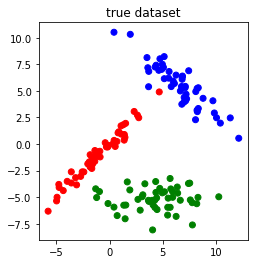

In [3]:
# change parallel_lines to orthogonal, triangle, lines_3D for other toy datasets
X,Y, X_noise, n_clusters = triangle(noise=0.1)

color= ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in Y.cpu().detach().numpy()]
plt.scatter(X_noise[:,0],X_noise[:,1], color = color)
plt.title('true dataset');plt.axis('image')
plt.show()

## Clustering
Use linear Autoencoder since the underlying structures are linear.
* Hyperparameters in the setting include <br>
`cnn = False` -- set to True for mnist and fashion <br>
`epochs = 200` -- change for testing <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`

* Set `repetition` to number of times the experiment to be repeated

**`kmeans_ari`, `ae_ari`, `tae_ari` are the lists of ari scores for the datasets ran for `repetition` number of times**

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

In [5]:
# kmeans_ari, ae_ari, tae_ari gives the ari of respective algorithms
# hyperparameters: repetition, epochs, lr, reg,  
repetition = 1
epochs = 50

np.random.seed(1)
ae_ari = []
tae_ari = []
kmeans_ari = []
ae_err = []
tae_err = []

dataset = 0
for (data_generation, lr) in [(parallel_line(noise=0), 0.01), 
                              (orthogonal(noise=0), 0.01), 
                              (triangle(noise=0),0.1), 
                              (lines_3D(noise=0),0.1)][:2]:
    dataset += 1
    print(f"Dataset {dataset}")
    ae = []
    tae = []
    kmeans_ = []
    ae_e = []
    tae_e = []
    for rep in range(repetition):
        print(f"Iteration {rep+1}")

        np.random.seed(rep)

        X,Y,X_noise,n_clusters = data_generation
        x_idx = torch.tensor(np.arange(X.shape[0]))
        shuffle_idx = torch.randperm(x_idx.shape[0])
        x_idx = x_idx[shuffle_idx].long()
        X = X[x_idx].clone().float().to(device)
        Y = Y[x_idx].clone()
        # X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
        # Y = torch.tensor(Y[x_idx])
        
        # k means
        k = KMeans(n_clusters=n_clusters, random_state=rep).fit(X.cpu().detach().numpy())
        k_ari = adjusted_rand_score(k.labels_, Y)
        kmeans_.append(k_ari)
        
        # Standard AE
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_AE(net, X, X, lr=0.01,epochs=epochs,verbose=1)
        ae_e.append(ae_l[-1])
        
        X_embed = net.enc1(X).cpu().detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)
        AE_clust_assign = kmeans.labels_
        ari = adjusted_rand_score(AE_clust_assign, Y)
        ae.append(ari)
        
        # Tensorized AE
        tae_m, tae_l, TAE_clust_assign, _ = train_TAE(X.clone(), X.clone(), n_clusters=n_clusters, lr=lr, reg=0.1, embed=1, epochs=epochs,verbose=1)
        tae_e.append(tae_l[-1])
        ari = adjusted_rand_score(TAE_clust_assign.cpu().detach().numpy(), Y)
        tae.append(ari)
        
    kmeans_ari.append(kmeans_)    
    ae_ari.append(ae)
    tae_ari.append(tae)
    ae_err.append(ae_e)
    tae_err.append(tae_e)
    
#consider only best 5 based on the loss
kmeans_ari = np.sort(np.array(kmeans_ari))[::-1][:5].squeeze()
ae_idx = np.argsort(np.array(ae_err))[:5].squeeze()
ae_ari = np.array(ae_ari)[ae_idx].squeeze()
tae_idx = np.argsort(np.array(tae_err))[:5].squeeze()
tae_ari = np.array(tae_ari)[tae_idx].squeeze()

Dataset 1
Iteration 1


Epoch: 50|50: 100%|███████████| 50/50 [00:11<00:00,  4.26it/s, loss 1.4207]
Epoch: 50|50: 100%|███████████| 50/50 [00:25<00:00,  1.98it/s, loss 1.2811]


Dataset 2
Iteration 1


Epoch: 50|50: 100%|███████████| 50/50 [00:11<00:00,  4.21it/s, loss 1.1104]
Epoch: 50|50: 100%|███████████| 50/50 [00:27<00:00,  1.82it/s, loss 1.1717]


In [10]:
print(tae_ari, ae_ari, kmeans_ari)

[0.08000279 0.08000279] [0.33981078 0.33981078] [0.97333216 0.26564316]


## Denoising

* Hyperparameters: <br>
`noise=0.1` -- noise level to add to the original data <br>
`epochs = 100` -- number of epochs <br>
`linear_ae = False` -- linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`
* Set the following parameters accordingly <br>
`repetition= 5` -- number of times to repeat the experiment
`n_clusters = 3` -- length of `class_labels_list` in the `real_data_loader` function

**`ae_loss`, `tae_loss` are the lists of mse errors for the datasets ran for `repetition` number of times**

In [7]:
# ae_loss and tae_loss has the mse of the data
repetition = 1
epochs = 100

np.random.seed(1)
ae_loss = []
tae_loss = []
dataset = 0
for data_generation in [parallel_line(noise=0.1) , orthogonal(noise=0.1), triangle(noise=0.1), lines_3D(noise=0.1)]:
    dataset += 1
    print(f"Dataset {dataset}")
    ae = []
    tae = []
    for rep in range(repetition):
        print(f"Iteration {rep+1}")

        np.random.seed(rep)

        X,Y,X_noise,n_clusters = data_generation

        # Standard AE
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_AE(net, X_noise, Y, lr=0.01,epochs=epochs,X_out=X)
        ae.append(ae_l[-1])

        # Tensorized AE
        _, tae_l, _, _, _, _ = train_TAE(X_noise.clone(),Y.clone(), n_clusters=n_clusters, lr=0.1, reg=0.1, embed=1, epochs=epochs, X_out=X.clone() )
        tae.append(tae_l[-1])
    
    ae_loss.append(ae)
    tae_loss.append(tae)

Dataset 1
Iteration 1
epoch  49  loss  1.4781457606330515
epoch  99  loss  1.4784668265158931
epoch  49  loss  0.11278917124960572
epoch  99  loss  0.07993478318909183
Dataset 2
Iteration 1
epoch  49  loss  1.0980033610854298
epoch  99  loss  1.098002887661957
epoch  49  loss  0.19484190337049465
epoch  99  loss  0.10100703348095218
Dataset 3
Iteration 1
epoch  49  loss  3.889700612503414
epoch  99  loss  3.8897747323599954
epoch  49  loss  0.21856595503399148
epoch  99  loss  0.16404234138162185
Dataset 4
Iteration 1
epoch  49  loss  0.8103261529266214
epoch  99  loss  0.8104534785348612
epoch  49  loss  0.05007408121755968
epoch  99  loss  0.025107430698893343


# Real Data

## Clustering
* pass `real_data_loader` with the following arguments for different datasets: <br>
penguin4:  `dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False` <br>
iris:     `dataset='iris', class_labels_list=[0,1,2], normalise_data=False, subsample=False` <br>
mnist:    `dataset='mnist', class_labels_list=[0,1,2,3,4], num_samples=200, normalise_data=False, subsample=True` <br>
fashion:  `dataset='fashion', class_labels_list=[0,1,2,3,4], num_samples=200, normalise_data=False, subsample=True` <br>
    
* Hyperparameters in the setting include <br>
`cnn = False` -- set to True for mnist and fashion <br>
`epochs = 200` -- change for testing <br>
`linear = False` -- whether to use linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`

* Set `repetition` to number of times the experiment to be repeated

**`kmeans_ari`, `ae_ari_1`, `ae_ari_2`, `tae_ari` are the lists of ari scores for the datasets ran for `repetition` number of times**

In [18]:
repetition = 1
cnn = False
epochs = 200
linear = False

kmeans_ari = []
ae_ari_1 = []
ae_ari_2 = []
tae_ari = []

for r in range(repetition):

    ##################################
    # penguin 4 Features
    ##################################

    # load data

    X,Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False)
    n_clusters = 3

    # k-means Benchmark
    k = KMeans(n_clusters=n_clusters, random_state=r).fit(X)
    kmeans_ari.append(adjusted_rand_score(k.labels_, Y.cpu().detach().numpy()))
    
    # simple AE embedding 1 
    net = Autoencoder(in_feature=X.shape[1],embed=1,linear=linear).to(device)
    train_loss = train_AE(net, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=cnn)

    X_embed = net.enc1(X.float().to(device)).cpu().detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)

    ae_ari_1.append(adjusted_rand_score(kmeans.labels_, Y.cpu().detach().numpy()))
    
    # simple AE embedding 3
    net = Autoencoder(in_feature=X.shape[1],embed=3,linear=linear).to(device)
    train_loss = train_AE(net, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=cnn)

    X_embed = net.enc1(X.float().to(device)).cpu().detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)

    ae_ari_2.append(adjusted_rand_score(kmeans.labels_, Y.cpu().detach().numpy()))
    
    # TAE

    _, train_loss, clust_assign, _, Y_t, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1, embed=1, linear=linear, epochs=epochs ,number_of_batches=1)

    tae_ari.append(adjusted_rand_score(torch.argmax(clust_assign,axis=0).cpu().detach().numpy(), Y_t.cpu().detach().numpy()))
    

torch.cuda.FloatTensor
epoch  49  loss  0.010615310762746783
epoch  99  loss  0.010615310553617464
epoch  149  loss  0.010615310687460229
epoch  199  loss  0.010615310750199024
torch.cuda.FloatTensor
epoch  49  loss  0.010651099377083119
epoch  99  loss  0.010650321630716414
epoch  149  loss  0.010649368399754167
epoch  199  loss  0.010648178941888098
epoch  49  loss  0.00247403455116632
epoch  99  loss  0.002131419018205307
epoch  149  loss  0.002000342559356708
epoch  199  loss  0.001953371702730654


In [19]:
print(ae_ari_1,ae_ari_2,tae_ari)

[0.19969729807824443] [0.19969729807824443] [0.6129439684022059]


## Denoising
* `real_data_loader` : use the above arguments for different datasets 
* Hyperparameters: <br>
`noise=0.1` -- noise level to add to the original data <br>
`epochs = 100` -- number of epochs <br>
`linear_ae = False` -- linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`
* Set the following parameters accordingly <br>
`repetition= 5` -- number of times to repeat the experiment
`n_clusters = 3` -- length of `class_labels_list` in the `real_data_loader` function

**`ae_mse`, `tae_mse` are the lists of mse errors for the datasets ran for `repetition` number of times**

In [20]:
#give different dataset name = ['penguin4', 'penguin2', 'iris', 'mnist', 'fashion']
X,Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False)
X_noise = add_noise_data(X, noise=0.1)

repetition = 5
n_clusters = 3
epochs = 100
linear_ae = False

ae_mse = []
tae_mse = []

for i in range(repetition):
    # simple AE embedding 1 
    net = Autoencoder(in_feature=X.shape[1],embed=1, linear=linear_ae).to(device)
    train_loss = train_AE(net, X_noise.float(),Y.float(), lr=0.001,epochs=epochs, X_out=X)
    ae_mse.append(train_loss[-1])

    # TAE
    _, train_loss, _, _, _, _ = train_TAE(X_noise.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1, embed=1, epochs=epochs, linear=linear_ae ,number_of_batches=1, X_out=X.clone())
    tae_mse.append(train_loss[-1])
print(ae_mse, tae_mse)

torch.cuda.FloatTensor
epoch  49  loss  0.013090794243080218
epoch  99  loss  0.01309079341736795
epoch  49  loss  0.002546129627496598
epoch  99  loss  0.0024431790537159043
torch.cuda.FloatTensor
epoch  49  loss  0.013090794557471296
epoch  99  loss  0.01309079341736795
epoch  49  loss  0.0025799256604977653
epoch  99  loss  0.0024827146708538677
torch.cuda.FloatTensor
epoch  49  loss  0.013090794123527956
epoch  99  loss  0.01309079463624334
epoch  49  loss  0.0026162708874541427
epoch  99  loss  0.002499219412189512
torch.cuda.FloatTensor
epoch  49  loss  0.013090794089718716
epoch  99  loss  0.01309079341736795
epoch  49  loss  0.002610447743235656
epoch  99  loss  0.002482026755986847
torch.cuda.FloatTensor
epoch  49  loss  0.01309079325389853
epoch  99  loss  0.01309079341736795
epoch  49  loss  0.00264372405614202
epoch  99  loss  0.0025026075396061844
[0.01309079341736795, 0.01309079341736795, 0.01309079463624334, 0.01309079341736795, 0.01309079341736795] [0.002443179053715904

In [3]:
#give different dataset name = ['penguin4', 'penguin2', 'iris', 'mnist', 'fashion']
X,Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False)
X_noise = X.clone()

for samp in X_noise:
    if np.random.rand() > 0.5:
        idx = np.random.randint(0,X.shape[1],size=2)
        samp[idx] = 0

repetition = 5
n_clusters = 3
epochs = 100
linear_ae = False

ae_mse = []
tae_mse = []

for i in range(repetition):
    # simple AE embedding 1 
    net = Autoencoder(in_feature=X.shape[1],embed=1, linear=linear_ae).to(device)
    train_loss = train_AE(net, X_noise.float(),Y.float(), lr=0.001,epochs=epochs, X_out=X)
    ae_mse.append(train_loss[-1])

    # TAE
    _, train_loss, _, _, _, _ = train_TAE(X_noise.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1, embed=1, epochs=epochs, linear=linear_ae ,number_of_batches=1, X_out=X.clone())
    tae_mse.append(train_loss[-1])
print(ae_mse, tae_mse)